# **The Code Behind AlexNet**

*By Cristian Leo*

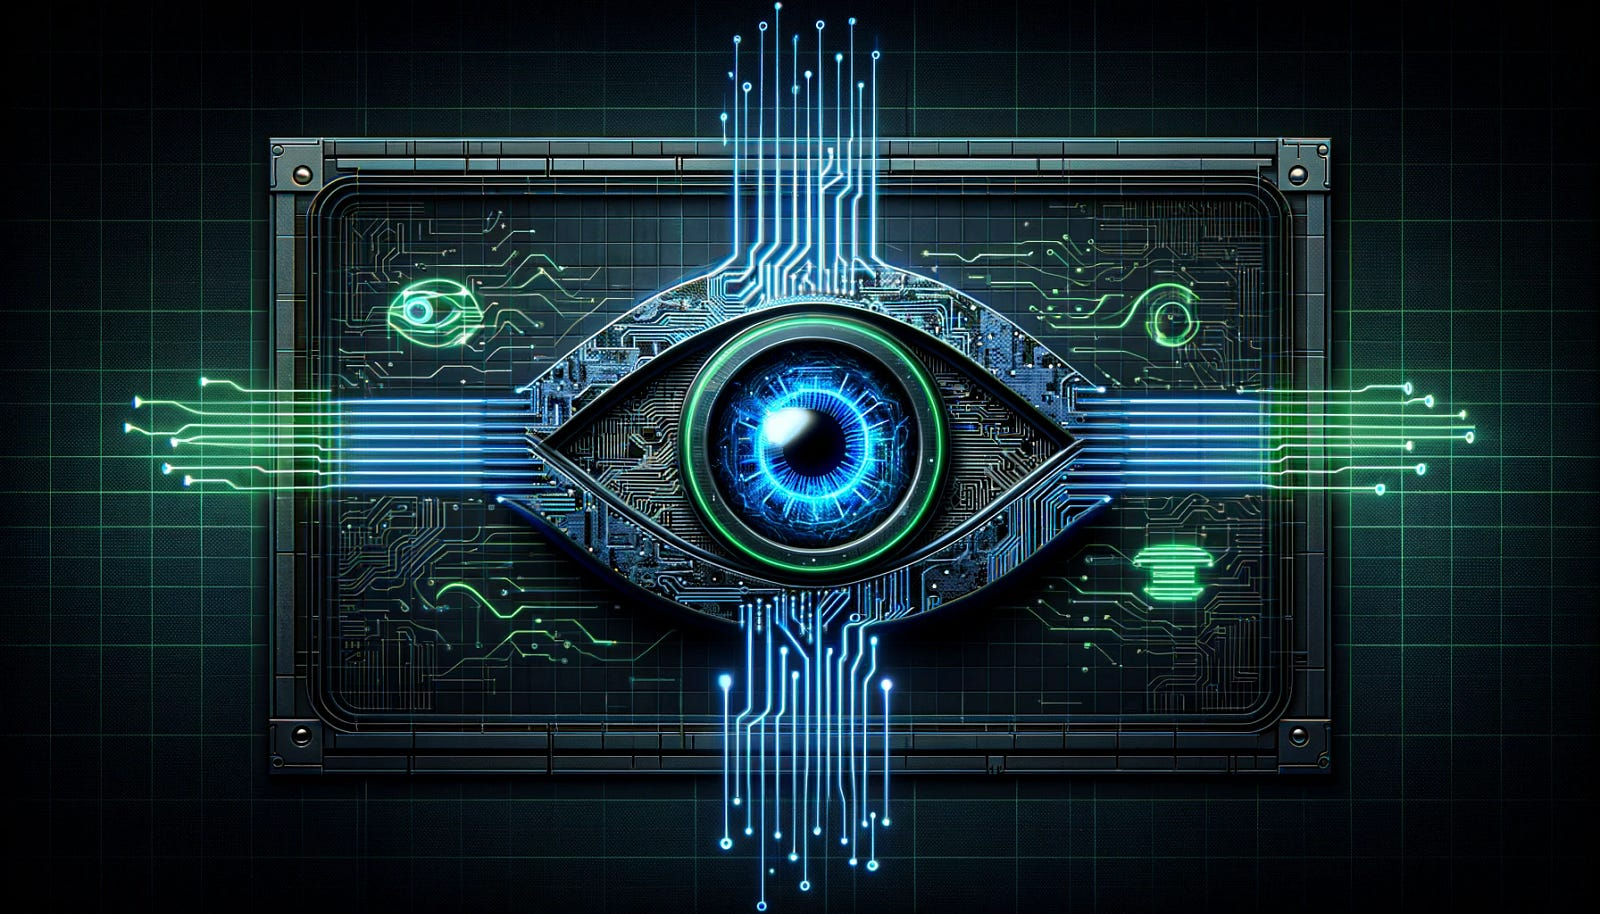

In [1]:
# PyTorch for creating and training the neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import random_split

# platform for getting the operating system
import platform

# torchvision for loading and transforming the dataset
import torchvision
import torchvision.transforms as transforms

# ReduceLROnPlateau for adjusting the learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau

# numpy for numerical operations
import numpy as np

# matplotlib for plotting
import matplotlib.pyplot as plt

In [ ]:
class AlexNet(nn.Module):
    """
    AlexNet model

    Args:
        num_classes (int): number of classes in the dataset. Default is 1000.
    """
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        """
        Forward pass of the model
        
        Args:
            x (torch.Tensor): input tensor of shape (N, C, H, W)
        
        Returns:
            torch.Tensor: output tensor of shape (N, num_classes)
        """
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [2]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after

    Args:
    -----
        patience (int): Number of epochs to wait before stopping the training.
        verbose (bool): If True, prints a message for each epoch where the loss
                        does not improve.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        """
        Args:
        -----
            val_loss (float): The validation loss to check if the model performance improved.
        
        Returns:
        --------
            bool: True if the loss did not improve, False if it improved.
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [3]:
class Trainer:
    """
    Trainer class to train the model.

    Args:
    -----
        model (nn.Module): Neural network model.
        criterion (torch.nn.modules.loss): Loss function.
        optimizer (torch.optim): Optimizer.
        device (torch.device): Device to run the model on.
        patience (int): Number of epochs to wait before stopping the training.
    """
    def __init__(self, model, criterion, optimizer, device, patience=7):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.early_stopping = EarlyStopping(patience=patience)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=3, verbose=True, factor=0.5, min_lr=1e-6)
        self.train_losses = []
        self.val_losses = []
        self.gradient_norms = []

    def train(self, train_loader, val_loader, epochs):
        """
        Train the model.
        
        Args:
        -----
            train_loader (torch.utils.data.DataLoader): DataLoader for training dataset.
            val_loader (torch.utils.data.DataLoader): DataLoader for validation dataset.
            epochs (int): Number of epochs to train the model.
        """
        for epoch in range(epochs):
            self.model.train()
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
            
            self.train_losses.append(loss.item())

            val_loss = self.evaluate(val_loader)
            self.val_losses.append(val_loss)
            self.scheduler.step(val_loss)
            self.early_stopping(val_loss)

            # Log the training and validation loss
            print(f'Epoch {epoch+1}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

            if self.early_stopping.early_stop:
                print("Early stopping")
                break

    def evaluate(self, test_loader):
        """
        Evaluate the model on the test dataset.

        Args:
        -----
            test_loader (torch.utils.data.DataLoader): DataLoader for test dataset.

        Returns:
        --------
            float: Average loss on the test dataset.
        """
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

        return total_loss / len(test_loader)
    
    def accuracy(self, test_loader):
        """
        Calculate the accuracy of the model on the test dataset.

        Args:
        -----
            test_loader (torch.utils.data.DataLoader): DataLoader for test dataset.

        Returns:
        --------
            float: Accuracy of the model on the test dataset.
        """
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return correct / total

    def plot_losses(self, window_size=100):
        # Compute moving averages
        train_losses_smooth = self.moving_average(self.train_losses, window_size)
        val_losses_smooth = self.moving_average(self.val_losses, window_size)

        # Plot
        plt.plot(train_losses_smooth, label='Train Loss')
        plt.plot(val_losses_smooth, label='Validation Loss')
        plt.legend()
        plt.grid()
        plt.title('Losses')

    def moving_average(self, data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.Resize((224, 224)),  # Resize images to 224x224 to match the input size of AlexNet
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# Define the classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:14<00:00, 11420599.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Split the dataset into training and validation sets
train_split = 0.8

train_size = int(train_split * len(trainset))
val_size = len(trainset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

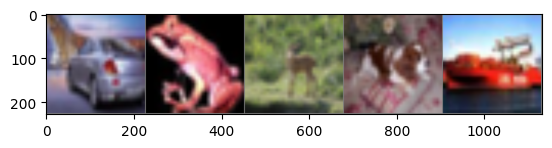

  car  frog  deer   dog  ship


In [16]:
# Get the first batch of images from the trainloader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images[:5]))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [6]:
# Check the system's operating system
if platform.system() == 'Darwin':  # Darwin stands for macOS
    try:
        device = torch.device('cuda')
        _ = torch.zeros(1).to(device)  # This will raise an error if CUDA is not available
    except:
        device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device.type

'mps'

In [7]:
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
trainer = Trainer(model, criterion, optimizer, device, patience=7)

# Train the model
trainer.train(train_loader, val_loader, epochs=50)

# Evaluate the model on the test set
test_loss = trainer.evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Calculate the accuracy on the test set
accuracy = trainer.accuracy(test_loader)
print(f'Test Accuracy: {accuracy :.2%}%')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 1.6848, Validation Loss: 1.6276
Epoch 2, Training Loss: 1.3936, Validation Loss: 1.1688
Epoch 3, Training Loss: 1.1116, Validation Loss: 0.9545
Epoch 4, Training Loss: 1.0321, Validation Loss: 0.8030
Epoch 5, Training Loss: 0.6169, Validation Loss: 0.7211
Epoch 6, Training Loss: 0.9001, Validation Loss: 0.7083
Epoch 7, Training Loss: 0.4127, Validation Loss: 0.6414
Epoch 8, Training Loss: 0.6169, Validation Loss: 0.6527
Epoch 9, Training Loss: 0.3146, Validation Loss: 0.6049
Epoch 10, Training Loss: 0.3554, Validation Loss: 0.5970
Epoch 11, Training Loss: 0.4381, Validation Loss: 0.6061
Epoch 12, Training Loss: 0.2960, Validation Loss: 0.6084
Epoch 13, Training Loss: 0.3705, Validation Loss: 0.6111
Epoch 14, Training Loss: 0.2831, Validation Loss: 0.5851
Epoch 15, Training Loss: 0.2090, Validation Loss: 0.6404
Epoch 16, Training Loss: 0.1800, Validation Loss: 0.6465
Epoch 17, Training Loss: 0.0556, Validation Loss: 0.6235
Epoch 18, Training Loss: 0.2044, Validat

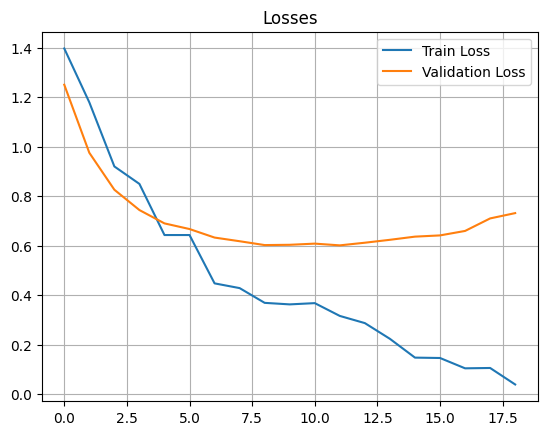

In [17]:
trainer.plot_losses(window_size=3)